In [1]:
import pandas as pd
from pathlib import Path

In [2]:
cwd = Path.cwd()

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

In [4]:
grades = pd.read_csv(cwd / 'food+establishment+grades.csv', parse_dates=['RESULTDTTM'], infer_datetime_format=True)
grades = grades.fillna('-').replace(' ','-')
grades['ISSDTTM'] = pd.to_datetime(grades['ISSDTTM'], errors='coerce')
grades['EXPDTTM'] = pd.to_datetime(grades['EXPDTTM'], errors='coerce')

In [5]:
failed_results = [
    'HE_Fail',
    'HE_FailExt',
    'HE_Filed',
    'HE_TSOP',
    'HE_Hearing',
    'HE_OutBus',
    'HE_Closure',
    'HE_Misc',
    'HE_FAILNOR'
]

# Initial Inspections

In [6]:
important_cols_df = grades[['LICENSENO', 'RESULT', 'RESULTDTTM', 'SUM_VIOLATIONS', 'SCORE', 'GRADE', 'LICENSECAT']]
important_cols_df['YEAR'] = important_cols_df.RESULTDTTM.dt.year

D:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [7]:
def split_by_year(dataframe):
    '''
    Split inputed dataframe into multiple dataframes returned in a dictionary with the year as the key.
    
    Parameters:
    dataframe (pd.DataFrame): Dataframe to be split
    
    Returns:
    dict: Dictionary of dataframes split by year, with each year as a key
    '''
    dataframe_by_year = {}
    for year in dataframe.YEAR.unique():
        dataframe_by_year[year] = dataframe[dataframe.YEAR == year]
    return dataframe_by_year

In [8]:
def get_initial_inspections(dataframe_dict):
    '''
    Build dictionary of dataframes representing the initial inspections of each establishment per year by sorting on timestamp
    when the inspection is logged and then grabbing the first record available after deduplication based on LICENSENOs
    
    Parameters:
    dataframe_dict (dict): Annually split dataframe dictionary to retrieve initial inspections from
    
    Returns:
    dict: Dictionary of dataframes containing initial inspections split by year
    '''
    initial_inspections_by_year = {}
    for year in dataframe_dict.keys():
        initial_inspections_by_year[year] = dataframe_dict[year].sort_values(by='RESULTDTTM').drop_duplicates(subset='LICENSENO', keep='first')
    return initial_inspections_by_year

In [9]:
important_cols_dfs_by_year = split_by_year(important_cols_df)

In [39]:
initial_inspections_by_year = get_initial_inspections(important_cols_dfs_by_year)

In [11]:
def get_nunique_licensenos(dataframe_dict):
    '''
    Calculate the number of unique LICENSENOs present in the provided dataframe dict per year
    
    Parameters:
    dataframe_dict (dict): Annually split dataframe dictionary to retrieve number of unique LICENSENOs from
    
    Returns:
    dict: Dictionary of dataframes containing the number of unique LICENSENOs observed split per year
    '''
    licensenos_per_year = {}
    for year in dataframe_dict.keys():
        licensenos_per_year[year] = dataframe_dict[year].LICENSENO.nunique()
    return licensenos_per_year

In [40]:
get_nunique_licensenos(initial_inspections_by_year)

{2012: 5409,
 2013: 4073,
 2014: 3885,
 2015: 3900,
 2016: 4085,
 2017: 4072,
 2018: 3009}

## Fails

In [12]:
def get_initial_fails(dataframe_dict):
    '''
    Build a dictionary of dataframes containing the records of establishments that failed their initial inspection per year
    
    Parameters:
    dataframe_dict (dict): Annually split dataframe dictionary to retrieve initial inspection failures from
    
    Returns:
    dict: Dictionary of dataframes containing information related to the establishments that failed their initial inspections
    '''
    initial_fails_by_year = {}
    for year in dataframe_dict.keys():
        relevant_df = dataframe_dict[year]
        initial_fails_by_year[year] = relevant_df[relevant_df.RESULT.isin(failed_results)]
    return initial_fails_by_year

In [13]:
initial_fails_by_year = get_initial_fails(initial_inspections_by_year)

In [14]:
def get_license_numbers_per_year(dataframe_dict):
    '''
    Retrieve lists of the LICENSENOs present in the provided dataframe dict per year. As this is run on initial_fails_by_year
    the LICENSENOs are already deduplicated and unique.
    
    Parameters:
    dataframe_dict (dict): Annually split dataframe dictionary to retrieve list of LICENSENOs from
    
    Returns:
    dict: Dictionary of dataframes containing the list of LICENSENOs observed split per year
    '''
    license_numbers = {}
    for year in dataframe_dict.keys():
        license_numbers[year] = dataframe_dict[year].LICENSENO.tolist()
    return license_numbers

In [15]:
initial_fail_licensenos_by_year = get_license_numbers_per_year(initial_fails_by_year)

# Reinspections

In [16]:
def get_reinspections(full_df, initial_inspections_df):
    '''
    Retrieve the reinspections per year based on (total inspections dataframe - initial inspections dataframe) per year
    
    Parameters:
    full_df (dict): Dictionary of dataframes representing all the inspections split per year
    initial_inspections_df (dict): Dictionary of dataframes representing the initial inspections split per year
    
    Returns:
    dict: Dictionary of dataframes containing the reinspections split per year
    '''
    reinspections_by_year = {}
    for year in full_df.keys():
        relevant_full_df = full_df[year]
        relevant_initial_inspections_df = initial_inspections_df[year]
        reinspections_by_year[year] = relevant_full_df[~relevant_full_df.isin(relevant_initial_inspections_df)].dropna(how='all')
    return reinspections_by_year

In [17]:
reinspections_by_year = get_reinspections(important_cols_dfs_by_year, initial_inspections_by_year)

## Number of repeat offenders based on failures in reinspections

In [18]:
def get_repeat_offenders_by_year(reinspections_by_year_dict, initial_fail_licensenos_by_year_dict):
    '''
    Retrieve the repeat offenders per year based on reinspections that fail (based on the failed_results variable defined above)
    
    Parameters:
    reinspections_by_year_dict (dict): Dictionary of dataframes representing all the reinspections split per year
    initial_fail_licensenos_by_year_dict (dict): Dictionary of lists containing the LICENSENOs of establishments that failed initial inspection per year
    
    Returns:
    dict: Dictionary of dataframes containing the reoffenders split per year
    '''
    repeat_offenders_by_year = {}
    for year in reinspections_by_year_dict.keys():
        reinspection_df = reinspections_by_year_dict[year]
        initial_fail_licensenos = initial_fail_licensenos_by_year_dict[year]
        repeat_offenders_by_year[year] = reinspection_df[reinspection_df.LICENSENO.isin(initial_fail_licensenos) & reinspection_df.RESULT.isin(failed_results)]
    return repeat_offenders_by_year

In [19]:
repeat_offenders_by_year = get_repeat_offenders_by_year(reinspections_by_year, initial_fail_licensenos_by_year)

In [20]:
repeat_offender_licensenos = get_nunique_licensenos(repeat_offenders_by_year)

In [21]:
nunique_licensenos_by_year = get_nunique_licensenos(important_cols_dfs_by_year)
nunique_licensenos_of_initial_fails = get_nunique_licensenos(initial_fails_by_year)
repeat_offenders_dict_for_plot = {}
for key, value in repeat_offender_licensenos.items():
    repeat_offenders_dict_for_plot[key] = [value, nunique_licensenos_by_year[key], nunique_licensenos_of_initial_fails[key]]
    print(f'{key}: {value} repeat reoffenders of {nunique_licensenos_by_year[key]} total establishments, {nunique_licensenos_of_initial_fails[key]} of which failed initial inspection')

2012: 1484 repeat reoffenders of 5409 total establishments, 2591 of which failed initial inspection
2013: 1260 repeat reoffenders of 4073 total establishments, 2546 of which failed initial inspection
2014: 1330 repeat reoffenders of 3885 total establishments, 2650 of which failed initial inspection
2015: 1554 repeat reoffenders of 3900 total establishments, 2734 of which failed initial inspection
2016: 1689 repeat reoffenders of 4085 total establishments, 2864 of which failed initial inspection
2017: 1409 repeat reoffenders of 4072 total establishments, 2704 of which failed initial inspection
2018: 667 repeat reoffenders of 3009 total establishments, 2221 of which failed initial inspection


In [22]:
repeat_offenders_plot_df = pd.DataFrame.from_dict(repeat_offenders_dict_for_plot, orient='index')

In [23]:
repeat_offenders_plot_df = repeat_offenders_plot_df.rename(columns={
    0:'Repeat Offenders', 
    1:'Total Establishments', 
    2:'Establishments that Performed Poorly During Initial Inspection'
})

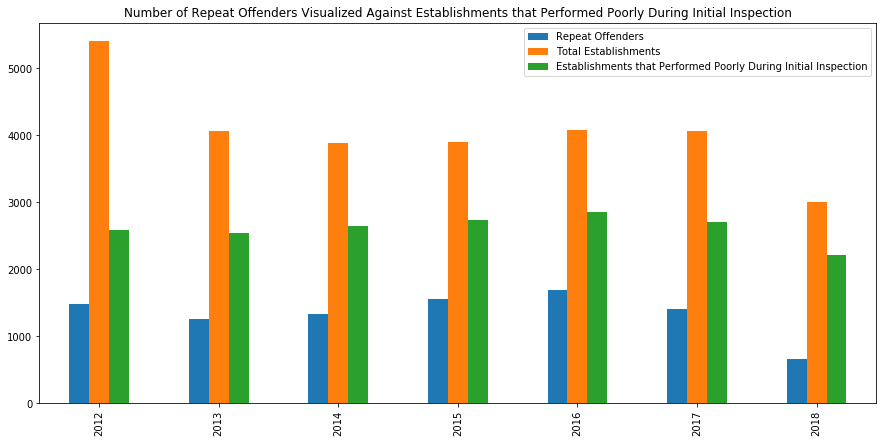

In [29]:
repeat_offenders_plot_df.plot(kind='bar', figsize=(15,7), title='Number of Repeat Offenders Visualized Against Establishments that Performed Poorly During Initial Inspection')

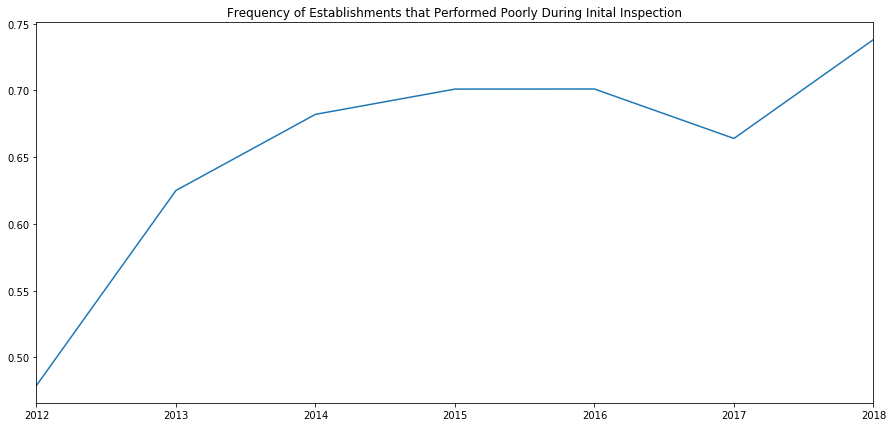

In [35]:
(repeat_offenders_plot_df['Establishments that Performed Poorly During Initial Inspection']/repeat_offenders_plot_df['Total Establishments']).plot(figsize=(15,7), title='Frequency of Establishments that Performed Poorly During Inital Inspection')

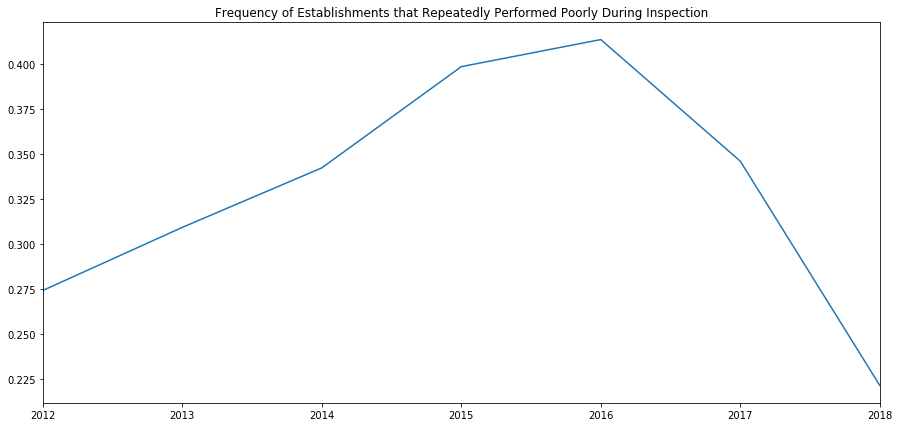

In [36]:
(repeat_offenders_plot_df['Repeat Offenders']/repeat_offenders_plot_df['Total Establishments']).plot(figsize=(15,7), title='Frequency of Establishments that Repeatedly Performed Poorly During Inspection')

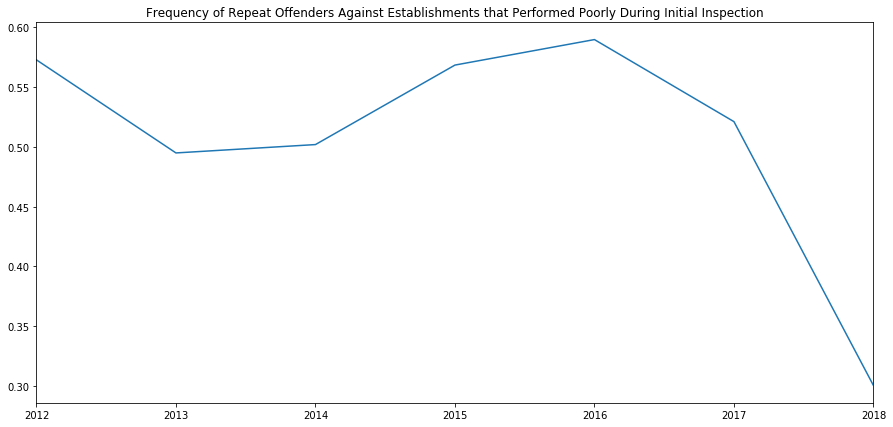

In [37]:
(repeat_offenders_plot_df['Repeat Offenders']/repeat_offenders_plot_df['Establishments that Performed Poorly During Initial Inspection']).plot(figsize=(15,7), title='Frequency of Repeat Offenders Against Establishments that Performed Poorly During Initial Inspection')

### Most common license categories for reoffenders (poor performers) per year

In [30]:
def get_license_categories(dataframe_dict):
    '''
    Calcuate most common license categories associated with provided dataframe.
    
    Parameters:
    dataframe_dict (dict): Dictionary of dataframes representing the repeat offenders split per year
    
    Returns:
    dict: Dictionary of lists of value counts of license categories associated with repeat offenders per year
    '''
    license_categories = {}
    for year in dataframe_dict.keys():
        relevant_df = dataframe_dict[year]
        license_categories[year] = relevant_df.LICENSECAT.value_counts().tolist()
    return license_categories

In [31]:
license_categories_for_repeat_offenders_per_year = get_license_categories(repeat_offenders_by_year)

In [32]:
license_categories_for_repeat_offenders_per_year_df = pd.DataFrame.from_dict(license_categories_for_repeat_offenders_per_year, orient='index')

In [33]:
license_categories_for_repeat_offenders_per_year_df = license_categories_for_repeat_offenders_per_year_df.rename(columns={
    0: 'Eating and Drinking Establishment (FS)',
    1: 'Eating and Drinking Establishment with Take-Out Service (FT)',
    2: 'Mobile Food Truck or Vendor (MFW)',
    3: 'Retail Food Establishment (RF)'
})

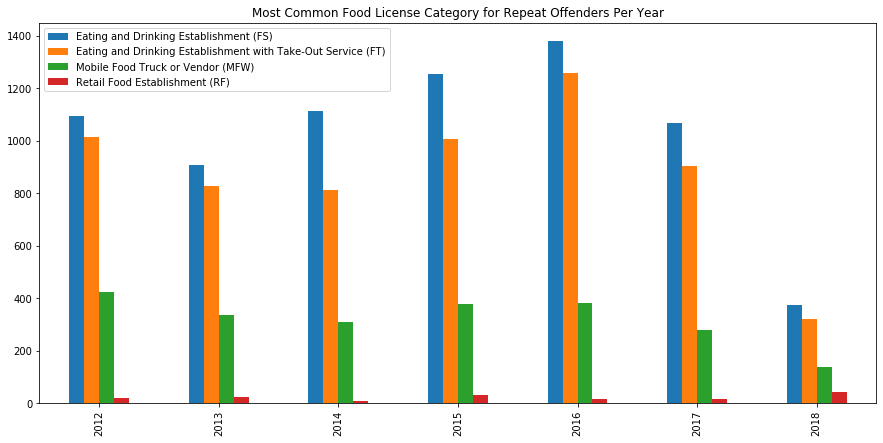

In [34]:
license_categories_for_repeat_offenders_per_year_df.plot(kind='bar', figsize=(15,7), title='Most Common Food License Category for Repeat Offenders Per Year')